In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import product
from competition.titanic.FeaturesEngineering import *
import warnings
warnings.filterwarnings("error", category=FutureWarning)

from sklearn.pipeline import Pipeline

(891, 11)
(891,)


In [2]:
df = pd.read_csv("../data/train.csv", delimiter=",")

features = [x for x in df.columns if x != "Survived"]
x, y = df[features], df["Survived"].T
print(x.shape)
print(y.shape)

(891, 11)
(891,)


In [3]:
X_train, X_cv, y_train, y_cv = train_test_split(x, y, train_size=0.8, random_state=1)

In [4]:
print(f"X train: {X_train.shape}")
print(f"Y train: {y_train.shape}")
print(f"X cv: {X_cv.shape}")
print(f"y cv: {y_cv.shape}")


X train: (712, 11)
Y train: (712,)
X cv: (179, 11)
y cv: (179,)


In [5]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8]
min_samples_split_list = [30, 50, 100, 150, 200, 250, 300]
n_estimators_list = [50, 100, 150, 200]

In [9]:
def eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_samples_split, n_estimators, feature_transformer):
    model = Pipeline(steps=[
        ("preprocessor", feature_transformer),
        ("classifier", RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              random_state=1))
    ])
    model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    train_accuracy = np.mean(y_train_hat == y_train)
    y_cv_hat = model.predict(X_cv)
    cv_accuracy = np.mean(y_cv == y_cv_hat)
    mean_accuracy = (train_accuracy + cv_accuracy)/2
    print(
        f"Max depth: {max_depth}, Min sample split: {min_samples_split}, N estimators: {n_estimators}, Train accuracy: {train_accuracy}, CV accuracy: {cv_accuracy}, Mean Accuracy: {mean_accuracy}")
    return model, max_depth, min_samples_split, n_estimators, train_accuracy, cv_accuracy, mean_accuracy


model_evals = [
    eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_samples_split, n_estimators, engineer_features()) for
    max_depth, min_samples_split, n_estimators in product(max_depth_list, min_samples_split_list, n_estimators_list)]

best_model_params = max(model_evals, key=lambda x: x[6])
print(best_model_params[-6:])

Max depth: 2, Min sample split: 30, N estimators: 50, Train accuracy: 0.7710674157303371, CV accuracy: 0.6927374301675978, Mean Accuracy: 0.7319024229489675
Max depth: 2, Min sample split: 30, N estimators: 100, Train accuracy: 0.7893258426966292, CV accuracy: 0.7821229050279329, Mean Accuracy: 0.785724373862281
Max depth: 2, Min sample split: 30, N estimators: 150, Train accuracy: 0.7893258426966292, CV accuracy: 0.776536312849162, Mean Accuracy: 0.7829310777728956
Max depth: 2, Min sample split: 30, N estimators: 200, Train accuracy: 0.7893258426966292, CV accuracy: 0.776536312849162, Mean Accuracy: 0.7829310777728956
Max depth: 2, Min sample split: 50, N estimators: 50, Train accuracy: 0.7710674157303371, CV accuracy: 0.6927374301675978, Mean Accuracy: 0.7319024229489675
Max depth: 2, Min sample split: 50, N estimators: 100, Train accuracy: 0.7893258426966292, CV accuracy: 0.7821229050279329, Mean Accuracy: 0.785724373862281
Max depth: 2, Min sample split: 50, N estimators: 150, Tra

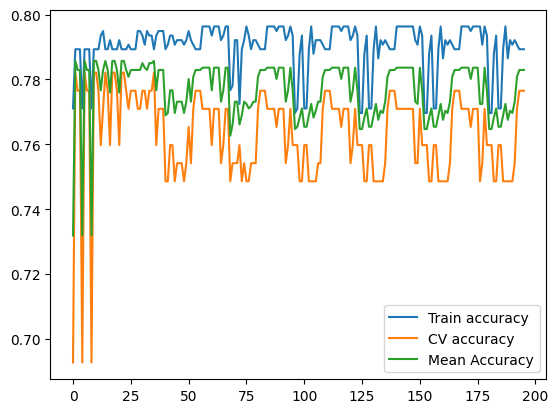

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
train_accuracy = [model[4] for model in model_evals]
cv_accuracy =[model[5] for model in model_evals]
mean_accuracy = [model[6] for model in model_evals]
plt.plot(range(len(model_evals)), train_accuracy)
plt.plot(range(len(model_evals)), cv_accuracy)
plt.plot(range(len(model_evals)), mean_accuracy)
plt.legend(["Train accuracy", "CV accuracy", "Mean Accuracy"])
plt.show()

In [8]:
df_test = pd.read_csv("../data/test.csv", delimiter=",")

best_model = best_model_params[0]
y_test_hat = best_model.predict(df_test)
output = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_test_hat
})
output.to_csv("submission.csv", index=False)